In [48]:
# Install the required packages

!pip install transformers==3.0.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
import torch.nn.functional as F
from transformers import pipeline, BertTokenizer, BertModel, TFBertModel, AutoModel, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import AdamW

device = torch.device("cuda")

In [117]:
# Import train, dev, and test data

train = pd.read_csv('train.tsv', sep = '\t')
dev = pd.read_csv('dev.tsv', sep = '\t')
test = pd.read_csv('test.tsv', sep = '\t')

In [118]:
train.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,


In [119]:
# Analyze what the text looks like

train['claim'][1]

'Annual Mammograms May Have More False-Positives'

In [120]:
train['explanation'][1]

'This article reports on the results of a study of nearly 170,000 women who had screening mammograms beginning between age 40-59. The study found that over ten years of screening mammograms, over half of the women will experience a false-positive recall for additional mammography. In addition, 7%-9% of the women will have a biopsy for a suspicious lump which is not cancerous. Both of those percentages decrease if the woman is screened every other year rather than every year. Even with biennial mammography, 41% of women will experience a\xa0recall over 10 years of mammography. The study’s Principal Investigator emphasized that “in most cases, a recall doesn’t mean you have cancer.”\xa0 She hoped this knowledge would reduce the anxiety of women who are recalled. The story never explained the size of the decrease in the number of false positives between annual (61.3%) and biennial screening (41.6%). Our first two reviewers were a researcher who specializes in health decisions and a breast

In [121]:
train['main_text'][1]

'While the financial costs of screening mammography & false-positive recalls & biopsies were not included in the study, readers would benefit from being reminded that recall mammography & biopsies increase patient financial costs. This article leads with valuable information for all women over age 40 by stating “Getting screening mammograms every two years instead of annually reduces the chance of a false alarm, a new study shows.”\xa0 Unfortunately the writer doesn’t quantify or elaborate adequately on that reduction. Instead, the writer later focuses on how women undergoing screening mammography shouldn’t be anxious if they experience a recall because over half of women who have screening mammograms for 10 years will be recalled. Readers would have been better served if the writer had emphasized the significant reduction in both recall mammograms & false-positive biopsies in women who are screened every two years rather than annually. Part of the continuing controversy\xa0over screen

In [122]:
# Take only the 4 important labels for classification
# Train and dev had some additional labels with a very lo frequency so those are removed.

labels = ['true', 'false', 'mixture', 'unproven']
train = train[train.label.isin(labels)]
dev = dev[dev.label.isin(labels)]
test = test[test.label.isin(labels)]

In [123]:
# Creatig a cumulative dataframe that contains all the text

cols = ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers',
       'main_text', 'sources', 'label', 'subjects']

df = train[cols].append(dev[cols]).append(test[cols])

In [124]:
# Check nmber of missing values
df.isnull().sum()

claim_id             0
claim                0
date_published    2398
explanation          0
fact_checkers        0
main_text            0
sources              1
label                0
subjects             0
dtype: int64

In [125]:
# Distribution of labels

df.label.value_counts()

true        6306
false       3769
mixture     1799
unproven     377
Name: label, dtype: int64

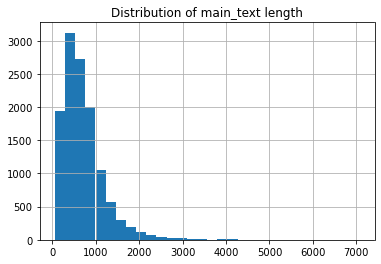

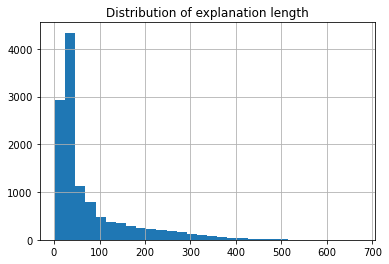

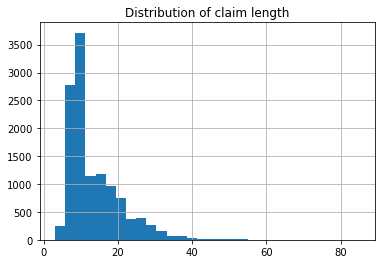

In [94]:
# Get lengths of claims, explanation, and main text to see how much to pad them
seq_len_maintext = [len(i.split()) for i in df.main_text]
seq_len_claim = [len(i.split()) for i in df.claim]
seq_len_explanation = [len(i.split()) for i in df.explanation]

pd.Series(seq_len_maintext).hist(bins = 30)
plt.title('Distribution of main_text length')
plt.show()
pd.Series(seq_len_explanation).hist(bins = 30)
plt.title('Distribution of explanation length')
plt.show()
pd.Series(seq_len_claim).hist(bins = 30)
plt.title('Distribution of claim length')
plt.show()

In [95]:
# Create a new column, appending claim, explanation and main text

train['input_text'] = train.claim + ' ' + train.explanation + ' ' + train.main_text
dev['input_text'] = dev.claim + ' ' + dev.explanation + ' ' + dev.main_text
test['input_text'] = test.claim + ' ' + test.explanation + ' ' + test.main_text
df['input_text'] = df.claim + ' ' + df.explanation + ' ' + df.main_text

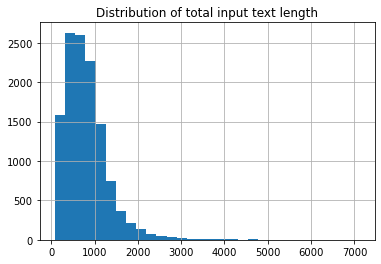

In [96]:
seq_len_input_text = [len(i.split()) for i in df.input_text]

pd.Series(seq_len_input_text).hist(bins = 30)
plt.title('Distribution of total input text length')
plt.show()

In [97]:
# We can fix a max length of 256 and if less than that, add padding. Not setting to higher due to model and training time
# constraints

In [61]:
unmasker = pipeline('fill-mask', model='bert-base-cased')
unmasker("Hello I'm a [MASK] model.")

C:\Users\srini\anaconda3\lib\site-packages\transformers\modeling_auto.py:791: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some

[{'score': 0.09019200503826141,
  'sequence': "[CLS] Hello I'm a fashion model. [SEP]",
  'token': 4633,
  'token_str': 'fashion'},
 {'score': 0.063500314950943,
  'sequence': "[CLS] Hello I'm a new model. [SEP]",
  'token': 1207,
  'token_str': 'new'},
 {'score': 0.06228220462799072,
  'sequence': "[CLS] Hello I'm a male model. [SEP]",
  'token': 2581,
  'token_str': 'male'},
 {'score': 0.04417290911078453,
  'sequence': "[CLS] Hello I'm a professional model. [SEP]",
  'token': 1848,
  'token_str': 'professional'},
 {'score': 0.033261489123106,
  'sequence': "[CLS] Hello I'm a super model. [SEP]",
  'token': 7688,
  'token_str': 'super'}]

In [98]:
# Initialize tokenizer and model to use
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained("bert-base-cased")

In [99]:
# Take only percentage of train/dev data - if required. To speed up training and evaluating
train = train[:8192]
dev = dev[:128]

In [100]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train.input_text.tolist(),
    max_length = 256,
    padding = 'max_length',
    truncation=True)
print('Done')

# tokenize and encode sequences in the dev set
tokens_dev = tokenizer.batch_encode_plus(
    dev.input_text.tolist(),
    max_length = 256,
    padding = 'max_length',
    truncation=True)
print('Done')

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test.input_text.tolist(),
    max_length = 256,
    padding = 'max_length',
    truncation=True)

Done
Done


In [101]:
# Encode labels to numeric values 0,1,2,3

le = LabelEncoder()
train_labels = le.fit_transform(train.label.tolist())
dev_labels = le.transform(dev.label.tolist())
test_labels = le.transform(test.label.tolist())

In [102]:
## convert lists to torch tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
#train_y = nn.functional.one_hot(torch.Tensor(train_labels).to(torch.int64), num_classes = 4)
train_y = torch.Tensor(train_labels).to(torch.int64)

dev_seq = torch.tensor(tokens_dev['input_ids'])
dev_mask = torch.tensor(tokens_dev['attention_mask'])
#dev_y = nn.functional.one_hot(torch.Tensor(dev_labels).to(torch.int64), num_classes = 4)
dev_y = torch.Tensor(dev_labels).to(torch.int64)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
#test_y = nn.functional.one_hot(torch.Tensor(test_labels).to(torch.int64), num_classes = 4)
test_y = torch.Tensor(test_labels).to(torch.int64)

In [103]:
# Split train, test, and dev data into batches

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [104]:
# Fix bert model architecture - no fine-tuning
for param in model.parameters():
    param.requires_grad = False

In [105]:
# Add to the existing BERT architecture the final layers that perform the multiclass classification task

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # Add dropout
        self.dropout = nn.Dropout(0.1)
        # ReLU activation
        self.relu =  nn.ReLU()
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(768,512)
        # Final layer
        self.fc2 = nn.Linear(512,4)
        
        # Softmax for multiclass likelihoods
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask = mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [106]:
# pass the pre-trained BERT to our defined architecture
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transfer_model = BERT_Arch(model)
#transfer_model = transfer_model.to(device)

In [107]:
# Define optimizer
optimizer = AdamW(transfer_model.parameters(), lr = 1e-5)  

In [108]:
# Due to class imbalance among claim classes, introduce class weights based on proportion in data
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print("Class Weights:",class_weights)

Class Weights: [0.81691264 1.68698517 0.48438978 8.42798354]


C:\Users\srini\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[0 1 1 ... 1 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [109]:
# Define accuracy per class and f1-score (Not used)

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [110]:
# Convert list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)

# Push to GPU
weights = weights.to(device)

# Define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight = weights) 

# Define number of training epochs
epochs = 2

In [111]:
def train():
  
    transfer_model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        print(step)
        # progress update after every 10 batches.
        if step % 10 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        transfer_model.zero_grad()        

        # get model predictions for the current batch
        preds = transfer_model(sent_id, mask)
        print('train done')
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)
        print(step)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [112]:
# function for evaluating the model
def evaluate(dev_dataloader):
  
    print("\nEvaluating...")

    # deactivate dropout layers
    transfer_model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(dev_dataloader):
        print(step)
        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dev_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd so that gradients don't update during evaluation
        with torch.no_grad():

            # model predictions
            preds = transfer_model(sent_id, mask)
            print('eval done')
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(dev_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [113]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate(dev_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transfer_model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
0
train done
0
1
train done
1
2
train done
2
3
train done
3
4
train done
4
5
train done
5
6
train done
6
7
train done
7
8
train done
8
9
train done
9
10
  Batch    10  of    256.
train done
10
11
train done
11
12
train done
12
13
train done
13
14
train done
14
15
train done
15
16
train done
16
17
train done
17
18
train done
18
19
train done
19
20
  Batch    20  of    256.
train done
20
21
train done
21
22
train done
22
23
train done
23
24
train done
24
25
train done
25
26
train done
26
27
train done
27
28
train done
28
29
train done
29
30
  Batch    30  of    256.
train done
30
31
train done
31
32
train done
32
33
train done
33
34
train done
34
35
train done
35
36
train done
36
37
train done
37
38
train done
38
39
train done
39
40
  Batch    40  of    256.
train done
40
41
train done
41
42
train done
42
43
train done
43
44
train done
44
45
train done
45
46
train done
46
47
train done
47
48
train done
48
49
train done
49
50
  Batch    50  of    256.
train done
50
51
train 

train done
139
140
  Batch   140  of    256.
train done
140
141
train done
141
142
train done
142
143
train done
143
144
train done
144
145
train done
145
146
train done
146
147
train done
147
148
train done
148
149
train done
149
150
  Batch   150  of    256.
train done
150
151
train done
151
152
train done
152
153
train done
153
154
train done
154
155
train done
155
156
train done
156
157
train done
157
158
train done
158
159
train done
159
160
  Batch   160  of    256.
train done
160
161
train done
161
162
train done
162
163
train done
163
164
train done
164
165
train done
165
166
train done
166
167
train done
167
168
train done
168
169
train done
169
170
  Batch   170  of    256.
train done
170
171
train done
171
172
train done
172
173
train done
173
174
train done
174
175
train done
175
176
train done
176
177
train done
177
178
train done
178
179
train done
179
180
  Batch   180  of    256.
train done
180
181
train done
181
182
train done
182
183
train done
183
184
train done
184


In [84]:
#load weights of best model
path = 'saved_weights.pt'
transfer_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [114]:
# Evaluate on batches of test data, collect final predictions
_, preds = evaluate(test_dataloader)


Evaluating...
0
eval done
1
eval done
2
eval done
3
eval done
4
eval done
5
eval done
6
eval done
7
eval done
8
eval done
9
eval done
10
  Batch    10  of     39.
eval done
11
eval done
12
eval done
13
eval done
14
eval done
15
eval done
16
eval done
17
eval done
18
eval done
19
eval done
20
  Batch    20  of     39.
eval done
21
eval done
22
eval done
23
eval done
24
eval done
25
eval done
26
eval done
27
eval done
28
eval done
29
eval done
30
  Batch    30  of     39.
eval done
31
eval done
32
eval done
33
eval done
34
eval done
35
eval done
36
eval done
37
eval done
38
eval done


In [115]:
# Get the predicted classes
preds = np.argmax(preds, axis = 1)

# Print model performance for each class
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.18      0.51      0.27       201
           2       0.54      0.56      0.55       599
           3       0.02      0.02      0.02        45

    accuracy                           0.35      1233
   macro avg       0.19      0.27      0.21      1233
weighted avg       0.29      0.35      0.31      1233



Future steps to improve model performance:

 - Longer sequences of input text
 - Trying other different BERT models
 - Generating data using GANs for under-represented classes instead of introducing class weights
 - Partial tuning of BERT weights instead of completely fixing them
 - More number of epochs